# Behavior cloning 
## on pseudo-driving data-set using Gaussian mixture model

Note that the variances of the GMM is set to ones (see function `get_gmm_from_params`). I tried to set them to learnable but then the model fails to converge consistently. This might be due to the fact that, for each observation, there are at most two possible actions, which can be unnatural to model using GMMs.

## Imports

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as D

In [2]:
import sys
sys.path.append('/home/yangz2/projects/bishop1995_notes/modules_for_nn_training')
from learner import Learner
from callbacks import CallbackHandler
from utility_callbacks import LossCallback
from trainer import Trainer

## Load data

In [3]:
with open('../data/pseudo_driving_dataset_multimodal.json', 'r') as json_f:
    states, actions = map(np.array, json.load(json_f))
    
states = states.reshape(-1, 10 * 40)  # flatten, to be fed into a fully-connected network as 1-d vectors
actions = actions[:,1].reshape(-1, 1)  # only take the delta_y's, since delta_x's are fixed 
# actions need no normalization

print(states.shape, actions.shape)
print(states.min(), states.max(), actions.min(), actions.max())

(226, 400) (226, 1)
0.0 1.0 -10 10


In [4]:
train_ds = TensorDataset(
    torch.from_numpy(states).float(), 
    torch.from_numpy(actions).float()
)
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)  # use a small batch size since our training set is small

## Define neural net that estimates distribution parameters

In [5]:
class ParamEstimator(nn.Module):
    
    def __init__(self, input_dim, output_dim, num_comps, num_hidden):
        
        super().__init__()
        
        self.num_comps = num_comps
        self.output_dim = output_dim
        
        self.get_mixing_coeffs = nn.Sequential(
            
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps),
            nn.Softmax(dim=1)
        
        )
        
        self.get_means = nn.Sequential(
        
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps * output_dim),
            
        )
        
        self.get_logvars = nn.Sequential(
        
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps),
        
        )
        
    def forward(self, x):
        
        mixing_coeffs = self.get_mixing_coeffs(x)
        means = self.get_means(x).view((-1, self.num_comps, self.output_dim))
        variances = torch.exp(self.get_logvars(x))
        
        return {
            'mixing_coeffs' : mixing_coeffs,
            'means' : means,
            'variances' : variances
        }

In [6]:
def get_gmm_from_params(params):
    
    # in this function, calling view on tensors are not supposed to change their shapes;
    # it just serves the purpose of making code easier to read and understand
    
    k = params['mixing_coeffs'].size(1)
    bs = params['mixing_coeffs'].size(0)  # may reduce at the end of an epoch, so don't set it to a fix number here
    dimension = 1  # we are predicting one variable here, so 1 dimensional gaussians are adequate
        
    mix = D.Categorical(params['mixing_coeffs'].view(bs, k))
    comp = D.Independent(
        D.Normal(
            params['means'].view(bs, k, dimension), 
            torch.ones(params['variances'].view(bs, k, dimension).size())
        ),
        reinterpreted_batch_ndims=1  # interpret the 1-st dimension as the "component" dimension
    )
    
    gmm = D.MixtureSameFamily(mix, comp)
    
    return gmm

In [7]:
def nll_loss(params, t):
    
    gmm = get_gmm_from_params(params)
    nll_loss = - torch.sum(gmm.log_prob(t.view(-1, 1)))
    
    return nll_loss

In [8]:
def get_model(**kwargs):
    model = ParamEstimator(**kwargs)
    return model, optim.Adam(model.parameters(), lr=10)

## Fine-tune learning rate

Simply pick the learning rate that corresponds to the steepest slope on the plot. No need to be super accurate.

In [9]:
train_again = True  # no need to train again since the model is saved can be loaded below

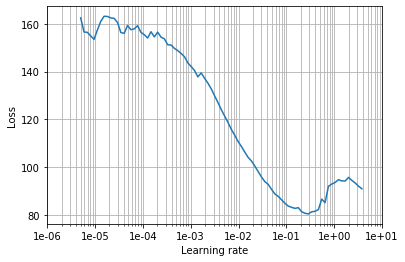

In [10]:
if train_again:
    
    model, opt = get_model(
        input_dim=400, 
        output_dim=1, 
        num_comps=2, 
        num_hidden=200
    )
    loss = nn.MSELoss()
    learn = Learner(train_dl, train_dl, model, nll_loss, opt)

    loss_cb = LossCallback()
    cb_handler = CallbackHandler(cbs=[loss_cb])

    trainer = Trainer(learn=learn, cb_handler=cb_handler)

    trainer.find_lr(beta=0.98, final_value=10, num_itr=100)

In [11]:
if train_again:
    trainer.set_lr(1e-2)

## Train neural net

In [12]:
if train_again:
    trainer.train(100)  # take less than 2 minutes since we are using a small dataset and a small network

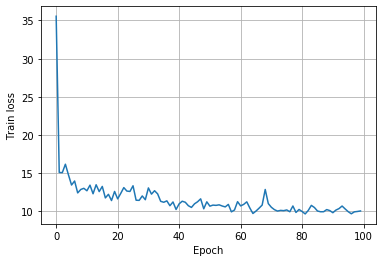

In [13]:
if train_again:
    loss_cb.plot()
    plt.ylabel('Train loss')
    plt.savefig('../results/multimodal_gmm_loss.png')

In [14]:
if train_again:
    trainer.save_as_pth('../results/multimodal_gmm.pth')

In [15]:
trainer.load_from_pth('../results/multimodal_gmm.pth')
model = trainer.learn.model
model = model.eval()

## Analyze results

In [18]:
with open('../data/pseudo_driving_track_multimodal.json', 'r') as json_f:
    track = np.array(json.load(json_f))
    track_vis = track.copy()  # for visualization later, no need to normalize

In [19]:
def get_state_from_coord(x, y):
    return track[x:x+10,y-20:y+20]

Rollout a trajectory in the state space using the policy learned.

In [20]:
x, y = 0, 60
state = get_state_from_coord(x, y)

xs_gen, ys_gen = [x], [y]
mixing_coeffs = []

for i in range(len(states) // 2):
    
    model.eval()
    state_preprocess = torch.from_numpy(state.reshape(1, 400)).float()
    params = model(state_preprocess)
    for k in params.keys():
        params[k] = params[k].detach().squeeze().numpy()
    delta_y = np.random.choice(params['means'], p=params['mixing_coeffs'])
    
    mixing_coeffs.append(params['mixing_coeffs'])
    
    # delta_y is the action to take in state_preprocess
    
    x, y = int(x + 5), int(y + delta_y)  # take action
    state = get_state_from_coord(x, y)  # observe the new state as a result of taking action
    
    xs_gen.append(x); ys_gen.append(y)

Visualize mixing coefficients along agent's trajectory.

In [21]:
mixing_coeffs = np.array(mixing_coeffs).reshape(-1, 2)

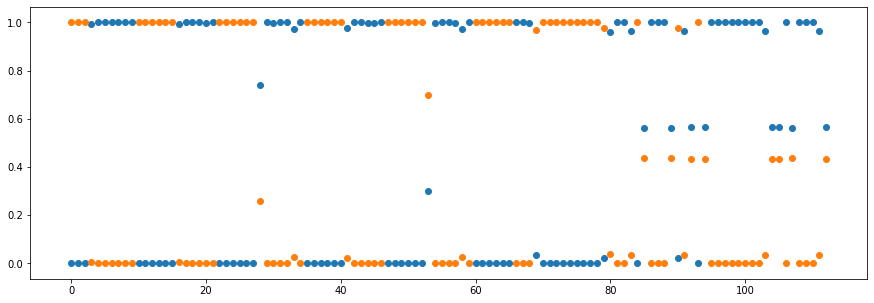

In [22]:
plt.figure(figsize=(15, 5))
plt.scatter(np.arange(len(mixing_coeffs[:,0])), mixing_coeffs[:,0])
plt.scatter(np.arange(len(mixing_coeffs[:,1])), mixing_coeffs[:,1])
plt.show()

Visualize the trajectory in the state space by highlighting the states visited by the agent.

In [23]:
for x, y in zip(xs_gen, ys_gen):
    track_vis[x, y] = 2

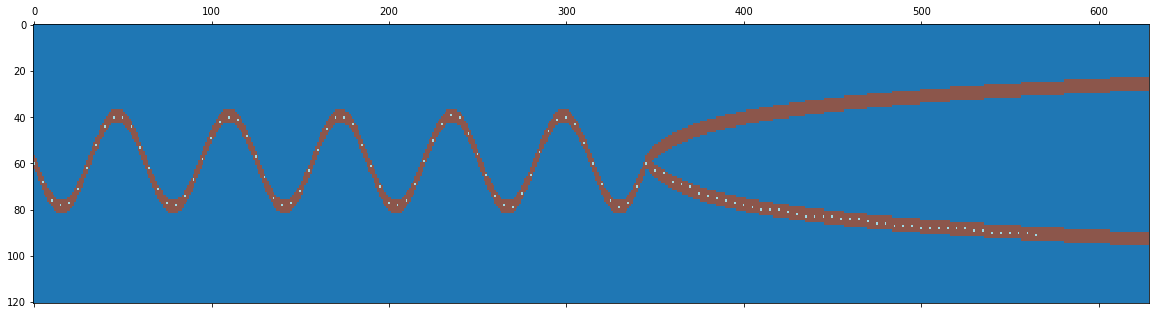

In [24]:
plt.figure(figsize=(20, 5))
plt.matshow(track_vis.T, fignum=1, aspect='auto', cmap='tab20')
plt.savefig('../results/multimodal_gmm_agent_trajectory.png')